In [1]:
import numpy as np
from pystac_client import Client
import rasterio as rio
from rasterio.windows import Window
import boto3
from tqdm import tqdm
import tqdm.notebook as tq

from typing import List, TypedDict, Tuple

In [2]:
h = 16
v = 5
region = 'CU'
#bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel']
#bands = ['diag', 'intr', 'intsm', 'inwam', 'mask', 'shade']
#bands = ['diag']
bands = ['intsm']

#cp = configparser.ConfigParser()
#cp.read(os.path.join(os.environ['HOME'],'.aws','credentials'))
#key = cp['default']['aws_access_key_id']
#secret = cp['default']['aws_secret_access_key']

stac = Client.open('https://landsatlook.usgs.gov/stac-server')

query = stac.search(collections=['landsat-c2l3-dswe'],
                    datetime='1980-01-01/2024-01-01',
                    query={'landsat:grid_horizontal': {'eq': f'{h:02}'},
                           'landsat:grid_vertical': {'eq': f'{v:02}'},
                           'landsat:grid_region': {'eq': region},
                           #'',
                           #'platform': {'eq': 'LANDSAT_8'},
                          }
                   )

stuff = query.get_all_items_as_dict()['features']
# dates = [pd.to_datetime(r['properties']['datetime'], utc=True) for r in stuff]


print(len(stuff))

4405


In [3]:
def session() -> rio.session.AWSSession:
    """
    Generate a rasterio AWS Session for reading data
    """
    return rio.session.AWSSession(boto3.Session(), requester_pays=True)

def open_tif(path: str):
    """
    Open a tif file
    """
    with rio.Env(session(), GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR'):
        return rio.open(path)

def read_tif(path: str, band: int = 1, window: Window = None):
    return open_tif(path).read(band, window=window)

def read_ls_data(item, band, window):
    return read_tif(item['assets'][band]['alternate']['s3']['href'], window=window)

def read_obs_chip(item, window, bands):
    return {b: read_ls_data(item, b, window) for b in bands}

In [4]:
in_path = stuff[0]['assets']['intsm']['alternate']['s3']['href']

In [5]:
class DataStack(TypedDict):
    """
    Container for storing chip data
    """
    h: int
    v: int
    window: Window
    acquired: List[str]
    data: np.ndarray

def sum_squares(arrs: List[np.ndarray]) -> np.ndarray:
    """
    Square and then sum all the values (element wise) in the given arrays
    """
    return np.ma.sum([np.ma.power(a, 2) for a in arrs], axis=0)

def difference(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    """
    Difference the two given arrays
    """
    return arr1 - arr2

def difference_absolute(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    """
    Calculate the absolute distance between the values in the two different arrays
    """
    return np.abs(difference(arr1, arr2))

def difference_median(arr: np.ndarray) -> np.ndarray:
    """
    Calculate the absolute difference each value is from the median
    """
    return difference_absolute(arr,
                               np.ma.median(arr, axis=0))
def dstack_idx(idxs: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Takes 2-d index returns from numpy.argmin or numpy.argmax on a stack where axis=0 and turns it into
    a tuple of tuples for indexing back into the 3-d array
    """
    return (idxs,
            np.repeat(np.arange(256).reshape(-1, 1), repeats=256, axis=1),
            np.array(list(range(256)) * 256).reshape(256, 256))

def distance_overall(spectral_stacks: dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Return the per-pixel index location for observations that come closest to the overall median value
    """
    #euc_dist = np.ma.sqrt(sum_squares([difference_median(spectral_stacks[k]) for k in spectral_stacks]))
    euc_dist = ((spectral_stacks[k]) for k in spectral_stacks)

    return dstack_idx(np.ma.argmin(euc_dist, axis=0))

def value_mask(arr: np.ndarray, value: int):
    """
    Create a mask where the specified value exists in the given array
    """
    return arr == value

def bitmask(arr: np.ndarray, bit: int) -> np.ndarray:
    """
    Create a boolean mask for where the bit is set in the given array
    """
    bit_val = 1 << bit
    return value_mask(arr & bit_val, bit_val)

def landsat_collection2(qa_arr: np.ndarray) -> np.ndarray:
    """
    Provide a default interpretation of the Landsat Collection 2 pixel quality
    layer for masking

    Reference:
    https://www.usgs.gov/media/files/landsat-8-9-olitirs-collection-2-level-2-data-format-control-book
    """
    return (bitmask(qa_arr, 0) |
             bitmask(qa_arr, 2) |
             bitmask(qa_arr, 3) |
             bitmask(qa_arr, 4) |
             bitmask(qa_arr, 5) |
             bitmask(qa_arr, 7))

def assemble_stacks(items, bands, window):
    out = {b: np.zeros(shape=(len(items), 256, 256), dtype=np.uint16) for b in bands}

    p_bar=tq.tqdm(range(len(items)), position=0, leave=True)
    for idx, item in enumerate(items):
        p_bar.update(1)
        p_bar.refresh()
        for b in bands:
            lsd = read_ls_data(item, b, window)
            out[b][idx][:lsd.shape[0], :lsd.shape[1]] = lsd
    

   # mask = landsat_collection2(out.pop('qa_pixel'))
    #return {k: np.ma.masked_array(val, dtype=val.dtype, mask=mask)
      #      for k, val in out.items()}
    return out

In [6]:
def median_distance(items, bands, window):
    data = assemble_stacks(items, bands, window)
    
    indxs = distance_overall(data)
    New_median_distance_data =  {k: val[indxs] for k, val in data.items()}
    return (data)
    #return dstack_idx(np.ma.argmin(data, axis=0))
    #return data

In [7]:
in_path

's3://usgs-landsat-level-3/collection02/DSWE/2023/CU/016/005/LC09_CU_016005_20231105_20231109_02_DSWE/LC09_CU_016005_20231105_20231109_02_INTSM.TIF'

In [8]:
%%time
window = Window(0, 0, 256, 256)

data = median_distance(stuff, bands, window)

  0%|          | 0/4405 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 5.12 s, total: 1min 41s
Wall time: 14min 30s


In [9]:
type(data)

dict

In [10]:
data.keys()

dict_keys(['intsm'])

In [11]:
type (data['intsm'])

numpy.ndarray

In [12]:
data['intsm'].shape

(4405, 256, 256)

In [13]:
import matplotlib.pyplot as plt

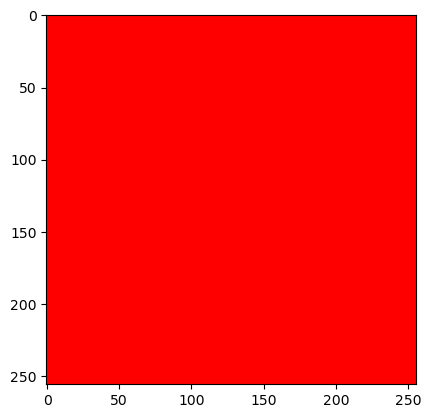

In [15]:
plt.imshow(data['intsm'][0], cmap='prism')

In [17]:
data['intsm'][0].min()

255

In [18]:
data['intsm'][0].max()

255

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([254.5, 254.6, 254.7, 254.8, 254.9, 255. , 255.1, 255.2, 255.3,
        255.4, 255.5]),
 <a list of 256 BarContainer objects>)

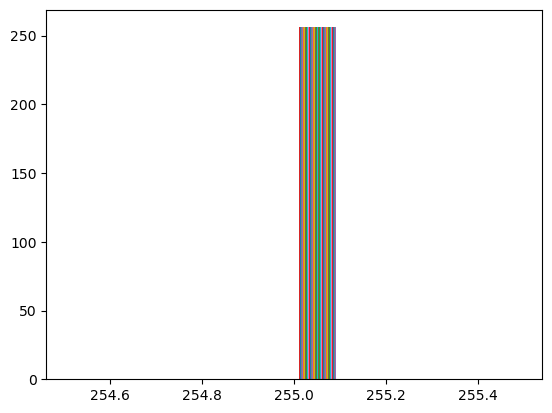

In [16]:
plt.hist(data['intsm'][0])b

In [ ]:
ary = data['intsm']

In [ ]:
ary[0:]

In [ ]:
plt.hist(ary[0], bins=50)

In [ ]:
ary[0].shape

In [ ]:
ary[1]

In [ ]:
ary[0]

In [ ]:
ary[200]